In [64]:
import numpy as np 
import pandas as pd 
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Import `fake_or_real_news.csv`
train = pd.read_csv('train_cleaned.csv')
test = pd.read_csv('test_cleaned.csv')
target = pd.DataFrame(train['label'])
#train = train.drop(['label'], axis = 1)
# Inspect shape
train.shape

(3999, 5)

In [65]:
train = train.set_index("Unnamed: 0")
test = test.set_index("Unnamed: 0")

train = train.drop(["Unnamed: 0.1"], axis = 1)
test = test.drop(["Unnamed: 0.1"], axis = 1)

In [45]:
# Print first lines
test.head()

,title,text,label
Unnamed: 0,,,
3999,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,FAKE
4000,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,REAL
4001,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,REAL
4002,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,REAL
4003,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,REAL


In [3]:
# delete unuseful columns
#train = train.drop(['X1'], axis = 1)
#train = train.drop(['X2'], axis = 1)

In [46]:
# create a function to check nulls
def check_nulls(df):
    nulls = np.sum(df.isnull())
    nullcols = nulls.loc[(nulls != 0)]
    dtypes = df.dtypes
    dtypes2 = dtypes.loc[(nulls != 0)]
    info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
    print(info)
    print("There are", len(nullcols), "columns with missing values")
    
# use the function    
check_nulls(train)   

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values


In [47]:
# Let's do a word cloud for FAKE and REAL news separated
# FAKE
fake = pd.DataFrame(train.loc[train['label'] == 'FAKE', 'text'])
# REAL
real = pd.DataFrame(train.loc[train['label'] == 'REAL', 'text'])

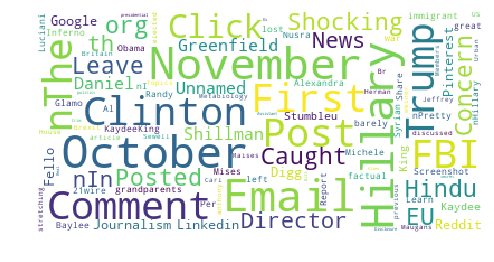

In [67]:
mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=100,
                          max_font_size=40, 
                          random_state=69
                         ).generate(str(fake['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

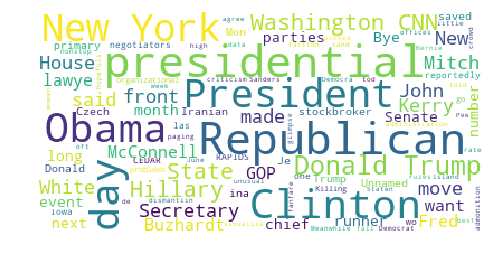

In [68]:
mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=100,
                          max_font_size=40, 
                          random_state=69
                         ).generate(str(real['text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [69]:
# We prepare a function to stem our text
# (taken from internet)
# https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_tfidf_vect = StemmedTfidfVectorizer(stop_words='english')

In [71]:
# Lemmatize
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [72]:
def LemTokens(tokens):
    lemmer = WordNetLemmatizer()
    return [lemmer.lemmatize(token) for token in tokens]


In [73]:
# Remove digits, words of less 3 letters and puntuaction
train['text'] = train['text'].str.replace('\d+', '') # for digits
#train['text'] = train['text'].str.replace(r'(\b\w{1,2}\b)', '') # for words
#train['text'] = train['text'].str.replace('[^\w\s]', '') # for punctuation 

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train['text'], 
                                                    target, test_size = 0.2, random_state = 69)

In [75]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(analyzer = 'word', strip_accents = 'ascii', 
                                   stop_words = ['english', 'russian'],
                                   #token_pattern = 'word',
                                   tokenizer = LemmaTokenizer(),       
                                   #ngram_range = (1, 1), 
                                   #min_df = 0.2,
                                   #max_df = 1,
                                   lowercase = True) 

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

# Transform the test set
count_test = count_vectorizer.transform(X_test)

In [76]:
# Initialize the `tfidf_vectorizer`
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', strip_accents = 'ascii', 
                                   stop_words = ['english', 'russian'],
                                   #token_pattern = 'word',
                                   tokenizer = LemmaTokenizer(),
                                   #ngram_range = (1, 1),
                                   #norm = 'l2',
                                   #min_df = 0.01,
                                   lowercase = True,
                                   max_df = 0.5) 
# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [14]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[:10])

# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])

['0', '00', '0000', '0002', '0007s', '001', '0026', '005', '007010', '007s']
['0', '00', '0000', '0002', '0007s', '001', '0026', '005', '007010', '007s']


In [15]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
difference = set(count_df.columns) - set(tfidf_df.columns)

In [16]:
print(count_df.equals(tfidf_df))

False


In [ ]:
"""

sparse matrix, in which the rows of the matrix
indicate documents (that is, articles messages) and the columns indicate terms (that is,
words). Each cell in the matrix stores a number indicating a count of the times the
word indicated by the column appears in the document indicated by the row.
"""

In [60]:
count_df.head()

,00,0000,0002,0007s,001,0026,005,007010,007s,01,...,zurita,zuroff,zuylenwood,zvezda,zvulun,zwanzig,zweiter,zwick,zwicker,zwischenmenschlich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
tfidf_df.head()

,00,0000,0002,0007s,001,0026,005,007010,007s,01,...,zurita,zuroff,zuylenwood,zvezda,zvulun,zwanzig,zweiter,zwick,zwicker,zwischenmenschlich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [77]:
# MODEL
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
clf = MultinomialNB() 

param_nb = {
    'alpha': np.linspace(0, 1, 20),
    'fit_prior': [True, False]
}

nb_random = RandomizedSearchCV(estimator = clf, param_distributions = param_nb, 
                                 n_iter = 40, 
                               cv = 10, verbose=2, random_state=69)

In [78]:
nb_random.fit(tfidf_train, y_train)
pred = nb_random.predict(tfidf_test)

cnf_matrix = confusion_matrix(y_test, pred)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting al

[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/skle

[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/diego/anaconda3/lib/python3.6/site-packages/skle

[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] .

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
accuracy:   0.917
Confusion matrix, without normalization
[[344  47]
 [ 19 390]]


In [79]:
# CounterVector
clf2 = MultinomialNB() 

param_nb_2 = {
    'alpha': np.linspace(0, 1, 20),
    'fit_prior': [True, False]
}

nb2_random = RandomizedSearchCV(estimator = clf2, param_distributions = param_nb_2, 
                                 n_iter = 40, 
                               cv = 10, verbose=2, random_state=69)

In [80]:
nb2_random.fit(count_train, y_train)
pred = nb2_random.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting al

[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0 .......................................
[CV] ........................ fit_prior=True, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/diego/anaconda3/lib/python3.6/site-packages/skle

[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/diego/anaconda3/lib/python3.6/site-packages/skle

[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=False, alpha=0.0 ......................................
[CV] ....................... fit_prior=False, alpha=0.0, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/diego/anaconda3/lib/python3.6/site-packages/skle

[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................
[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.0526315789474 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=True, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.0526315789474 ..........................
[CV] ........... fit_prior=False, alpha=0.0526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.105263157895 ............................
[CV] ............. fit_prior=True, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................
[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=False, alpha=0.105263157895 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.105263157895, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.157894736842 ............................
[CV] ............. fit_prior=True, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=False, alpha=0.157894736842 ...........................
[CV] ............ fit_prior=False, alpha=0.157894736842, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.210526315789 ............................
[CV] ............. fit_prior=True, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.1s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.1s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=False, alpha=0.210526315789 ...........................
[CV] ............ fit_prior=False, alpha=0.210526315789, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.263157894737 ............................
[CV] ............. fit_prior=True, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=False, alpha=0.263157894737 ...........................
[CV] ............ fit_prior=False, alpha=0.263157894737, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.315789473684 ............................
[CV] ............. fit_prior=True, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=False, alpha=0.315789473684 ...........................
[CV] ............ fit_prior=False, alpha=0.315789473684, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.368421052632 ............................
[CV] ............. fit_prior=True, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................
[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=False, alpha=0.368421052632 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.368421052632, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.421052631579 ............................
[CV] ............. fit_prior=True, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=False, alpha=0.421052631579 ...........................
[CV] ............ fit_prior=False, alpha=0.421052631579, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................
[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.473684210526 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=False, alpha=0.473684210526 ...........................
[CV] ............ fit_prior=False, alpha=0.473684210526, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.526315789474 ............................
[CV] ............. fit_prior=True, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................
[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=False, alpha=0.526315789474 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.526315789474, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.578947368421 ............................
[CV] ............. fit_prior=True, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=False, alpha=0.578947368421 ...........................
[CV] ............ fit_prior=False, alpha=0.578947368421, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................
[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.631578947368 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=False, alpha=0.631578947368 ...........................
[CV] ............ fit_prior=False, alpha=0.631578947368, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.684210526316 ............................
[CV] ............. fit_prior=True, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................
[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=False, alpha=0.684210526316 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.684210526316, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.736842105263 ............................
[CV] ............. fit_prior=True, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=False, alpha=0.736842105263 ...........................
[CV] ............ fit_prior=False, alpha=0.736842105263, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................
[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.789473684211 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=False, alpha=0.789473684211 ...........................
[CV] ............ fit_prior=False, alpha=0.789473684211, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.842105263158 ............................
[CV] ............. fit_prior=True, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................
[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=False, alpha=0.842105263158 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.842105263158, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.894736842105 ............................
[CV] ............. fit_prior=True, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=False, alpha=0.894736842105 ...........................
[CV] ............ fit_prior=False, alpha=0.894736842105, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=0.947368421053 ............................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.1s
[CV] fit_prior=True, alpha=0.947368421053 ............................
[CV] ............. fit_prior=True, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................
[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=False, alpha=0.947368421053 ...........................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ............ fit_prior=False, alpha=0.947368421053, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=True, alpha=1.0 .......................................
[CV] ........................ fit_prior=True, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] ....................... fit_prior=False, alpha=1.0, total=   0.0s
[CV] fit_prior=False, alpha=1.0 ......................................
[CV] .

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   15.7s finished
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column

In [81]:
# Passive Agressive Classifier
from sklearn.linear_model import PassiveAggressiveClassifier

pass_agg = PassiveAggressiveClassifier()

param_pass = {
    'fit_intercept': [True, False],
    'max_iter': np.linspace(1, 20, 20),
    'shuffle': [True, False],
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    
}

random_pass = RandomizedSearchCV(estimator = pass_agg, param_distributions = param_pass, 
                                 n_iter = 100, cv = 10, verbose=2, random_state=69)

In [82]:
random_pass.fit(tfidf_train, y_train)

pred = random_pass.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning

[CV]  shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=5.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False 
[CV]  shuf

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False 
[CV]  shuf

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=log, fit_intercept=True ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=11.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=11.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=log, fit_intercept=True ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=2.0, loss=perceptron, fit_int

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=2.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=11.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=True, max_iter=10.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=4.0, loss=hinge, fit_interce

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True, total=   0

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffl

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=modified_huber, fit_intercept=False

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=T

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=3.0, loss=percep

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False, tot

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=20.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=18.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=18.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=18.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=18.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=18.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=18.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=18.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=18.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=18.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=18.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=10.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=10.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=10.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=10.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=10.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=10.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=10.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=10.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=10.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=10.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=10.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=20.0, loss=squared_hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=17.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=16.0, loss=hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=13.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=13.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=13.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=13.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=log, fit_intercept=False .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=13.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=13.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=13.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=13.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=log, fit_intercept=False .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=13.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=13.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=13.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=13.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=14.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False ...


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False ...


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=10.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=True .......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=True .......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=True .......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=True .......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=True .......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=True .......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=True .......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=True .......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=17.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False .....
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False .....
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False .....
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False .....
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False .....
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False .....
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False .....
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False .....
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False .....
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=10.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=6.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[C

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=18.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=12.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=6.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=8.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=8.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=8.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=log, fit_intercept=False ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=8.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=8.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=8.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=8.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=8.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=log, fit_intercept=False ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=8.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=8.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True .


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True .


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=True, max_iter=12.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=19.0, loss=log, fit_intercept=True ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[CV] shuffle=False, max_iter=19.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=log, fit_intercept=True ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True .


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True .


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=9.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True .


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=4.0, loss=perceptron, fit_intercept

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=16.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False, total=   0.0s


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=False, max_iter=1.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuf

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=2.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True, total=   0.0s

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=3.0, 

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=3.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=False, max_iter=1.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=False, max_iter=1.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=False, max_iter=1.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=False, max_iter=1.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=False, max_iter=1.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=1.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffl

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=1.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=2.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=9.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=3.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=3.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=3.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=3.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=3.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=3.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=3.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=3.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=3.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=3.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=13.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=15.0, loss=perceptron, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=8.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] sh

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True .....
[CV]  shuffle=False, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=False ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=False ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=9.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=9.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=7.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=8.0, loss=modified_huber, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=16.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=16.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=log, fit_intercept=False .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=16.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=16.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=16.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=16.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=log, fit_intercept=False .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=16.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=16.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=16.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=16.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=16.0, loss=log, fit_intercept=False .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=16.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=True ........
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=True ........
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=True ........
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=True ........
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=True ........
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=True ........


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=True ........
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=True ........
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=True ........
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=True ........
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=log, fit_intercept=False ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=log, fit_intercept=False ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=13.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=16.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=11.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=False, max_iter=12.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False ...


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False ...


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False ...


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=10.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=20.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=20.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=20.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=20.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=20.0, loss=log, fit_intercept=False .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=20.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=20.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=20.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=20.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=20.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=20.0, loss=log, fit_intercept=False .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=False, max_iter=20.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=20.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=20.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=20.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=20.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=20.0, loss=log, fit_intercept=False .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=False, max_iter=20.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=20.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=20.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=4.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=F

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True 
[CV]  shuffle=False, max_iter=7.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=12.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=2.0, loss=log, fit_intercept=False ......
[CV]  shuffle=False, max_iter=2.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=False, max_iter=14.0, loss=squared_hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=8.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=14.0, loss=log, fit_intercept=True ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=14.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=14.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=14.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=14.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=log, fit_intercept=True ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=14.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=14.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=14.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=14.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=log, fit_intercept=True ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=14.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=14.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=14.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False ....
[CV]  shuffle=True, max_iter=15.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s


[CV] shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=10.0, loss=squared_hinge, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuf

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=4.0, loss=modified_huber, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True ......
[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=3.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=False, max_iter=19.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True 
[CV]  shuffle=True, max_iter=20.0, loss=modified_huber, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=False .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=False .......
[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=7.0, loss=log, fit_intercept=False .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=7.0, loss=log, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False 
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=11.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=11.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=11.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=11.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=False, max_iter=7.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True ....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True ....
[CV]  shuffle=False, max_iter=11.0, loss=hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True .


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept=True .
[CV]  shuffle=True, max_iter=3.0, loss=perceptron, fit_intercept

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=False ......
[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=False ......
[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=False ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=False ......
[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=False ......
[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=False ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=False ......
[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=False ......
[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=19.0, loss=log, fit_intercept=False ......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  shuffle=True, max_iter=19.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=18.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=18.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=18.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=18.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=18.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=18.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=18.0, loss=log, fit_intercept=False .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=18.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=18.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=18.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=18.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=18.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=18.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=18.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=18.0, loss=log, fit_intercept=False .....


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=18.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=18.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=18.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=18.0, loss=log, fit_intercept=False .....
[CV]  shuffle=False, max_iter=18.0, loss=log, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=12.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=12.0, loss=log, fit_intercept=True, total=   0.1s
[CV] shuffle=True, max_iter=12.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=log, fit_intercept=True .......
[CV]  shuffle=True, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=log, fit_intercept=True .......


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False 
[CV]  shuffle=True, max_iter=12.0, loss=squared_hinge, fit_intercept=False, total=   0.0s
[CV] shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False 
[CV]  shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=14.0, loss=modified_huber, fit_intercept=False, total=   0.1s
[CV] shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True 
[CV]  shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=True, max_iter=9.0, loss=squared_hinge, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s


[CV] shuffle=False, max_iter=12.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=12.0, loss=log, fit_intercept=True ......
[CV]  shuffle=False, max_iter=12.0, loss=log, fit_intercept=True, total=   0.0s
[CV] shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, m

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False ...


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False, total=   0.1s
[CV] shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False ...
[CV]  shuffle=False, max_iter=19.0, loss=hinge, fit_intercept=False, total=   0.1s


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   48.7s finished
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A colu

accuracy:   0.936
Confusion matrix, without normalization
[[373  18]
 [ 33 376]]


In [83]:
# SVM for text classification with counvectorizer
from sklearn.linear_model import SGDClassifier
svm = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state = 69, max_iter = 5, tol = None)

param_grid = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l1', 'l2'],
    'alpha': np.linspace(0.0001, 1, 10),
    'max_iter': [5,6,7,8,9,10],
    'eta0': np.linspace(0.1, 1, 10),
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'class_weight': ['balanced', None]
}

svm_random = RandomizedSearchCV(estimator = svm, param_distributions = param_grid, n_iter = 100, 
                               cv = 10, verbose=2, random_state=69)

In [84]:
svm_random.fit(count_train, y_train)
pred = svm_random.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112, total=   0.1s

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[CV] penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=optimal, eta0=0.3, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.5, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=1.0, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0 
[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0 
[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0 
[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0 
[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0 
[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=constant, eta0=0.9, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889, total=   0.2s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889, total=   0.2s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334, total=   0.2s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334, total=   0.2s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.2, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.9, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.5, class_weight=balanced, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l1, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.6667, total=   0.2s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=0.6, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=modified_huber, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.1, class_weight=None, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=0.5, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001 
[CV]  penalty=l1, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=constant, eta0=0.4, class_weight=None, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.7, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=perceptron, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.6, class_weight=balanced, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=optimal, eta0=0.3, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.8, class_weight=None, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.5, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=optimal, eta0=0.4, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=1.0, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.2, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112 
[CV]  penalty=l2, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0, total=   0.2s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0, total=   0.2s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667, total=   0.2s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667 
[CV]  penalty=l1, max_iter=7, loss=hinge, learning_rate=constant, eta0=1.0, class_weight=None, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.1, class_weight=balanced, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=optimal, eta0=1.0, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.9, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0, total=   0.1s

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=log, learning_rate=optimal, eta0=0.1, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.2, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=0.4, class_weight=balanced, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, class_weight=balanced, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889 
[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.1, class_weight=balanced, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=1.0, class_weight=balanced, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556 
[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=perceptron, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.3, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.6, class_weight=balanced, alpha=0.0001, total=   0.2s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=optimal, eta0=0.7, class_weight=None, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.8, class_weight=balanced, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.2, class_weight=balanced, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0 
[CV]  penalty=l2, max_iter=5, loss=log, learning_rate=constant, eta0=0.8, class_weight=balanced, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=optimal, eta0=0.8, class_weight=None, alpha=0.1112, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.7, class_weight=None, alpha=0.3334, total=   0.1s


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.9min finished
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy:   0.881
Confusion matrix, without normalization
[[319  72]
 [ 23 386]]


In [85]:
# SVM for text classification with tfidf vectorizer
from sklearn.linear_model import SGDClassifier
svm2 = SGDClassifier()

# We create the grid with different values to run RandomSearch later
param_grid = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': np.linspace(0.0001, 1, 10),
    'max_iter': [5,6,7,8,9,10],
    'eta0': np.linspace(0.1, 1, 10),
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    #'class_weight': ['balanced', None]
}

In [86]:
svm2_random = RandomizedSearchCV(estimator = svm2, param_distributions = param_grid, n_iter = 100, 
                               cv = 10, verbose=2, random_state=69)

In [87]:
svm2_random.fit(tfidf_train, y_train)
pred = svm2_random.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning

[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=0.8, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=i

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=invscaling, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=optimal, eta0=0.7, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0 
[CV]  penalty=l2, max_ite

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.3, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556 
[CV]

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.5, alpha=0.5556, total=   0.0s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=5, loss=squared_hinge, learning_rate=constant, eta0=0.7, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.3334, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=9, loss=perceptron, learning_rate=invscaling, eta0=1.0, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.8889 
[CV]  pena

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.8889 
[CV]  penalty=l2, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=perceptron, learning_rate=i

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, le

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, lea

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=8, loss=hinge, learning_rate=invscaling, eta0=0.1, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.4, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3,

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223 
[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0, total=   0.2s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0, total=   0.2s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0, total=   0.2s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0, total=   0.2s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0, total=   0.2s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0, total=   0.2s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0, total=   0.2s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0, total=   0.2s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0, total=   0.2s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=1.0, total=   0.2s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learn

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=5, loss=modified_huber, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.4, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445, total=   0.2s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.8, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778 
[CV]  penalty=l2, max_iter=5, loss=hinge, learning_rate=optimal, eta0=0.3, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334 
[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334 
[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334 
[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334 
[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334 
[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334 
[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334 
[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.3, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.1, alpha=0.2223 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.1, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.1, alpha=0.2223 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.1, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.1, alpha=0.2223 
[CV]  pena

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.1, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.1, alpha=0.2223 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.1, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.1, alpha=0.2223 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.1, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.1, alpha=0.2223 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.1, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.1, alpha=0.2223 
[CV]  penalty=l2, max_iter=5, loss=modified_huber, learning_rate=optimal, eta0=0.1, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=modified_huber, le

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445 
[CV]  penalty=l

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=7, loss=hinge, learning_rate=invscaling, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=constant, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=8, loss=hinge, learning_rate=constant, eta0=0.7, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=0.9, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscal

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.8, alpha=1.0, total=   0.0s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0 
[CV]  penalty=l2, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=1.0, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223 
[CV]  penalty=l1, max_iter=8, loss=perceptron, learning_rate=constant, eta0=0.7, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=perceptron, learning_rate=constant, eta0=0.8, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889, total=   0.0s
[CV] penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889, total=   0.0s
[CV] penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889, total=   0.0s
[CV] penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=5, loss=modified_huber, learning_rate=constant, eta0=0.4, alpha=0.8889, total=   0.0s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778 
[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778 
[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778 
[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778 
[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778 
[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778 
[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223 
[CV]  penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=7, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.2223, total=   0.1s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334 
[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334 
[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334 
[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334 
[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334 
[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334 
[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334 
[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334 
[CV]  penalty=l2, max_iter=5, loss=perceptron, learning_rate=constant, eta0=0.9, alpha=0.3334, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778 
[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778 
[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778 
[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778 
[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778 
[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778 
[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778 
[CV]  penalty=l1, max_iter=5, loss=log, learning_rate=optimal, eta0=0.4, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 
[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=c

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=6, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.0s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=log, learning_rate=constant, eta0=0.4, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778 
[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778 
[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778 
[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778 
[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778 
[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778 
[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778 
[CV]  penalty=elasticnet, max_iter=10, loss=squared_hinge, learning_rate=invscaling, eta0=0.9, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 
[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=log, learning_rate=constant, eta0=0.7, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.1, alpha=0.0001, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.6, alpha=0.1112, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, le

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.4, alpha=0.6667, total=   0.0s
[CV] penalty=elasticnet, max_iter=8, loss=modified_h

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0 
[CV]  penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0 
[CV]  penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0 
[CV]  penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0 
[CV]  penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0 
[CV]  penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0 
[CV]  penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=modified_huber, learning_rate=optimal, eta0=0.9, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.1, alpha=0.3334, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=squared

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rat

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556 
[CV]  penalty=l2, max_iter=6, loss=squared_hinge, learning_rate=optimal, eta0=1.0, alpha=0.5556, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667, tot

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=invscaling, eta0=0.7, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=constant, eta0=1.0, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0 
[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0 
[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0 
[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0 
[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0 
[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0 
[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.1, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112 
[CV]  penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=5, loss=hinge, learning_rate=invscaling, eta0=1.0, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.2, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.8889, total=   0.1s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889 
[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889 
[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889 
[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889 
[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889 
[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889 
[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889 
[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889 
[CV]  penalty=l2, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.8889, total=   0.0s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=modified_huber, learning_rate=constant, eta0=0.9, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0 
[CV]  penalty=l2,

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.1, alpha=1.0, total=   0.0s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=7, loss=log, learning_rate=constant, eta0=0.1, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=9, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223 
[CV]  penalty=l1, max_iter=8, loss=modified_huber, learning_rate=invscaling, eta0=0.5, alpha=0.2223, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223 
[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=7, loss=perceptron, learning_rate=invscaling, eta0=0.6, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, lear

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, lea

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.4445, total=   0.0s
[CV] penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.0s
[CV] penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.0s
[CV] penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.0s
[CV] penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.0s
[CV] penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.0s
[CV] penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.0s
[CV] penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.0s
[CV] penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=5, loss=log, learning_rate=invscaling, eta0=0.4, alpha=0.5556, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001 
[CV]  penalty=l2, max_iter=9, loss=log, learning_rate=invscaling, eta0=0.8, alpha=0.0001, total=   0.0s
[CV] penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=7, loss=modified_huber, learning_rate=constant, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0 
[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=log, learning_rate=invscaling, eta0=0.7, alpha=1.0, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778 
[CV]  penalty=l1, max_iter=10, loss=perceptron, learning_rate=constant, eta0=1.0, alpha=0.7778, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rat

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667 
[CV]  penalty=l2, max_iter=8, loss=squared_hinge, learning_rate=optimal, eta0=0.9, alpha=0.6667, total=   0.0s
[CV] penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alp

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l1, max_iter=8, loss=hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.1s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=constant, eta0=0.5, alpha=0.1112 
[CV]  penalty=l2, max_iter=7, loss=log, learni

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=constant, eta0=0.5, alpha=0.1112 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=constant, eta0=0.5, alpha=0.1112 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=constant, eta0=0.5, alpha=0.1112 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=constant, eta0=0.5, alpha=0.1112 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=log, learning_rate=constant, eta0=0.5, alpha=0.1112 
[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=c

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=7, loss=log, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.0s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667 
[CV]  penalty=l1, max_iter=8, loss=lo

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667, total=   0.1s
[CV] penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667 
[CV]  penalty=l1, max_iter=8, loss=log, learning_rate=invscaling, eta0=1.0, alpha=0.6667, total=   0.1s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334 
[CV]  penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3334, total=   0.0s
[CV] penalty=l2, max_iter=9, loss=perceptron, learning_rate=optimal, eta0=0.8, alpha=0.3

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.3, alpha=0.4445, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556 
[CV]  penalty=l1, max_iter=6, loss=hinge, learning_rate=invscaling, eta0=0.2, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=invscaling, eta0=0.6, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001 
[CV]  penalty=elasticnet, max_iter=6, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.0001, total=   0.1s
[CV] penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223 
[CV]  penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223 
[CV]  penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223 
[CV]  penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223 
[CV]  penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223 
[CV]  penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223 
[CV]  penalty=l2, max_iter=6, loss=

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s


[CV]  penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223 
[CV]  penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223 
[CV]  penalty=l2, max_iter=6, loss=hinge, learning_rate=constant, eta0=0.9, alpha=0.2223, total=   0.0s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889 
[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=hinge, learning_rate=constant, eta0=1.0, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112 
[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112 
[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112 
[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112 
[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112 
[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112 
[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112 
[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112 
[CV]  penalty=l1, max_iter=7, loss=modified_huber, learning_rate=invscaling, eta0=0.3, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445, total=   0.0s
[CV] penalty=ela

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445, total=   0.0s
[CV] penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445 
[CV]  penalty=elasticnet, max_iter=6, loss=perceptron, learning_rate=optimal, eta0=0.9, alpha=0.4445, total=   0.0s
[CV] penalty=l1,

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112 
[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=10, loss=hinge, learning_rate=optimal, eta0=1.0, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112 
[CV]  penalty=elasticnet, max_iter=8, loss=squared_hinge, learning_rate=constant, eta0=0.5, alpha=0.1112, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778, total=   0.1s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778 
[CV]  penalty=l1, max_iter=6, loss=squared_hinge, learning_rate=constant, eta0=0.8, alpha=0.7778, total=   0.0s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889 
[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=l1, max_iter=9, loss=hinge, learning_rate=optimal, eta0=0.5, alpha=0.8889, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556 
[CV]  penalty=elasticnet, max_iter=10, loss=log, learning_rate=constant, eta0=0.4, alpha=0.5556, total=   0.1s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, le

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778 
[CV]  penalty=l2, max_iter=10, loss=squared_hinge, learning_rate=optimal, eta0=0.1, alpha=0.7778, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=squared_hi

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=

/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223, total=   0.0s
[CV] penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223 
[CV]  penalty=l2, max_iter=7, loss=squared_hinge, learning_rate=invscaling, eta0=0.3, alpha=0.2223, total=   0.0s
accuracy:   0.931
Confusion matrix, without normalization
[[373  18]
 [ 37 372]]


/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.1min finished
/home/diego/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [99]:
# COMPARISON BETWEEN MODELS
from sklearn.metrics import roc_curve

plt.figure(0).clf()

for model, name in [ (nb_random, 'multinomial nb count'),
                     (nb2_random, 'multinomial nb tfidf'),
                     #(random_pass, 'passive aggressive count'),
                     (svm_random, 'svm count'),
                     (svm2_random, 'svm tfidf') ]:
    if 'count' in name:
        pred = model.predict_proba(count_test)[:,1]
    elif 'multinomial' in name:
        pred = model.predict_proba(tfidf_test)[:,1]
    else: 
        pred = model.decision_function(tfidf_test)
    fpr, tpr, thresh = roc_curve(y_test.values, pred, pos_label='REAL')
    plt.plot(fpr,tpr,label="{}".format(name))

plt.legend(loc=0)
plt.show()

ValueError: dimension mismatch